#  Building a Factor-Based Model to Spot Mispriced Stocks
This Jupyter notebook is a supplementary resource for the article.
It contains all the code snippets and examples discussed in the article,
providing a hands-on approach to understanding the concepts and techniques presented.
For a comprehensive understanding, please refer to the article at
https://entreprenerdly.com/


<p align="left">
  <img src="https://bit.ly/3FB10Z4" height=400>
</p>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Get and Process Fama-French 5-Factor Data

This script downloads daily Fama-French 5-factor data directly from the Dartmouth website. It extracts, cleans, and formats the data into a structured Pandas DataFrame. The cleaned dataset includes factors like market excess return (MKT_RF), size (SMB), value (HML), profitability (RMW), investment (CMA), and the risk-free rate (RF).

In [ ]:
import requests
import zipfile
import io
import re
import pandas as pd
import yfinance as yf

class FamaFrenchDownloader:
    """Downloads and processes Fama-French 5-factor data (daily)."""

    FF5_URL = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip"

    @staticmethod
    def download_ff5():
        """Fetches and extracts F-F 5-Factor data from the web."""
        response = requests.get(FamaFrenchDownloader.FF5_URL)
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            file_name = z.namelist()[0]
            with z.open(file_name) as f:
                return f.read().decode("utf-8").splitlines()

    @staticmethod
    def parse_ff5_data():
        """Extracts and cleans F-F 5-Factor data."""
        lines = FamaFrenchDownloader.download_ff5()

        # Keep only data lines (starting with 8-digit dates)
        data_lines = [line for line in lines if re.match(r'^\s*\d{8}', line)]

        # Read into DataFrame
        df = pd.read_csv(io.StringIO("\n".join(data_lines)), sep=r"\s*,\s*", header=None, engine="python")

        # Assign column names
        df.columns = ["Date", "MKT_RF", "SMB", "HML", "RMW", "CMA", "RF"]

        # Convert date column
        df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d", errors="coerce")

        # Convert numeric columns
        df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors="coerce")

        return df

# Usage (Fixed)
ff5_df = FamaFrenchDownloader.parse_ff5_data()
ff5_df

,Date,MKT_RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1,1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
2,1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
3,1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
4,1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...,...
15476,2024-12-24,1.11,-0.12,-0.05,-0.13,-0.37,0.017
15477,2024-12-26,0.02,1.09,-0.19,-0.44,0.35,0.017
15478,2024-12-27,-1.17,-0.44,0.56,0.41,0.03,0.017
15479,2024-12-30,-1.09,0.24,0.74,0.55,0.14,0.017


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


# Get and Process Fama-French Momentum Factor Data

Download daily Momentum Factor data from Dartmouth’s Fama-French database. Extract, clean, and structure it into a Pandas DataFrame. The output contains momentum factor returns (MOM) with corresponding dates, ready for analysis.

In [ ]:
import requests
import zipfile
import io
import re
import pandas as pd

class MomentumDownloader:
    """Downloads and processes the Fama-French Momentum Factor data (daily)."""

    MOM_URL = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_daily_CSV.zip"

    @staticmethod
    def download_momentum():
        """Fetches and extracts the Momentum Factor data from the web."""
        response = requests.get(MomentumDownloader.MOM_URL)
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            file_name = z.namelist()[0]
            with z.open(file_name) as f:
                return f.read().decode("utf-8").splitlines()

    @staticmethod
    def parse_momentum_data():
        """Extracts and cleans the Momentum Factor data (daily)."""
        lines = MomentumDownloader.download_momentum()

        # Keep only data lines (starting with 8-digit YYYYMMDD)
        data_lines = [line for line in lines if re.match(r'^\s*\d{8}', line)]

        # Read into DataFrame
        df = pd.read_csv(io.StringIO("\n".join(data_lines)), sep=r"\s*,\s*", header=None, engine="python")

        # Assign column names
        df.columns = ["Date", "MOM"]

        # Convert date column
        df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d", errors="coerce")

        # Convert MOM to numeric
        df["MOM"] = pd.to_numeric(df["MOM"], errors="coerce")

        # Drop invalid rows
        df.dropna(subset=["Date", "MOM"], inplace=True)

        return df

# Usage
mom_df = MomentumDownloader.parse_momentum_data()
mom_df

,Date,MOM
0,1926-11-03,0.56
1,1926-11-04,-0.50
2,1926-11-05,1.17
3,1926-11-06,-0.03
4,1926-11-08,-0.01
...,...,...
25795,2024-12-24,0.67
25796,2024-12-26,0.01
25797,2024-12-27,-0.88
25798,2024-12-30,0.06


# Download and Format Stock Price Data from Yahoo Finance

Fetch stock data from Yahoo Finance for multiple tickers. Compute daily returns and apply custom weights for portfolio-level analysis.

In [ ]:
import yfinance as yf
import pandas as pd

class StockDataFetcher:
    """Downloads and processes stock data from Yahoo Finance."""

    @staticmethod
    def get_stock_data(tickers, weights, start_date="1990-01-01"):
        """
        Fetch stock data for multiple tickers and compute weighted daily returns.

        Parameters:
        tickers (list): List of stock tickers (e.g., ["AAPL", "MSFT"])
        weights (list): List of weights (e.g., [0.3, 0.7]). Must match length of tickers.
        start_date (str): Start date for historical data.

        Returns:
        DataFrame: Contains Date, stock prices, and portfolio daily returns.
        """
        if len(tickers) != len(weights):
            raise ValueError("Tickers and weights must have the same length")

        # Fetch data using default auto_adjust=True.
        raw_df = yf.download(tickers, start=start_date, progress=False, group_by="ticker")

        # Process multi-ticker data.
        if isinstance(raw_df.columns, pd.MultiIndex):
            # Use 'Adj Close' if available, else use 'Close'
            level_vals = raw_df.columns.get_level_values(1)
            price_col = "Adj Close" if "Adj Close" in level_vals else "Close"
            price_cols = [col for col in raw_df.columns if col[1] == price_col]
            raw_df = raw_df[price_cols]
            raw_df.columns = [col[0] for col in raw_df.columns]
        else:
            # For single ticker downloads.
            price_col = "Adj Close" if "Adj Close" in raw_df.columns else "Close"
            raw_df = raw_df[[price_col]]
            raw_df.columns = tickers

        # Ensure the DataFrame columns follow the order of tickers.
        raw_df = raw_df[tickers]

        # Compute daily returns.
        returns_df = raw_df.pct_change() * 100

        # Compute weighted portfolio return.
        portfolio_return = returns_df.dot(weights)

        # Combine data.
        final_df = raw_df.copy()
        final_df["Portfolio Return"] = portfolio_return
        final_df.reset_index(inplace=True)

        return final_df

# Usage Example:
tickers = ["AAPL", "MSFT"]
weights = [0.3, 0.7]
stock_df = StockDataFetcher.get_stock_data(tickers, weights)
stock_df


YF.download() has changed argument auto_adjust default to True


,Date,AAPL,MSFT,Portfolio Return
0,1990-01-02,0.261842,0.378501,NaN
1,1990-01-03,0.263599,0.380633,0.595807
2,1990-01-04,0.264478,0.391828,2.158832
3,1990-01-05,0.265357,0.382233,-1.614614
4,1990-01-08,0.267114,0.388096,1.272510
...,...,...,...,...
8857,2025-03-04,235.929993,388.609985,-0.243052
8858,2025-03-05,235.740005,401.019989,2.211246
8859,2025-03-06,235.330002,396.890015,-0.773084
8860,2025-03-07,239.070007,393.309998,-0.154634


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


# Merge Factor Data with Stock Returns

Merge Fama-French 5-Factor data and Momentum Factor data on Date. Merge these factors with stock returns data. Drop rows with missing values. Display the final dataset.

In [ ]:
# Merge Fama-French 5-Factor and Momentum Factor data
merged_factors_df = pd.merge(ff5_df, mom_df, on="Date", how="outer")

# Merge with stock returns (use a general stock DataFrame, e.g., stock_df)
final_df = pd.merge(stock_df, merged_factors_df, on="Date", how="inner")
final_df.dropna(inplace=True)

# Display final merged dataset
final_df


,Date,AAPL,MSFT,Portfolio Return,MKT_RF,SMB,HML,RMW,CMA,RF,MOM
1,1990-01-03,0.263599,0.380633,0.595807,-0.06,0.72,-0.26,0.14,-0.43,0.026,-0.31
2,1990-01-04,0.264478,0.391828,2.158832,-0.71,0.44,-0.22,-0.06,-0.03,0.026,-0.38
3,1990-01-05,0.265357,0.382233,-1.614614,-0.85,0.74,-0.21,-0.01,-0.12,0.026,-0.33
4,1990-01-08,0.267114,0.388096,1.272510,0.30,-0.40,-0.26,0.06,0.31,0.026,0.18
5,1990-01-09,0.264478,0.387030,-0.488353,-1.01,0.87,0.07,-0.11,0.14,0.026,0.15
...,...,...,...,...,...,...,...,...,...,...,...
8812,2024-12-24,257.916443,438.450836,1.000512,1.11,-0.12,-0.05,-0.13,-0.37,0.017,0.67
8813,2024-12-26,258.735504,437.233276,-0.099117,0.02,1.09,-0.19,-0.44,0.35,0.017,0.01
8814,2024-12-27,255.309296,429.668457,-1.608373,-1.17,-0.44,0.56,0.41,0.03,0.017,-0.88
8815,2024-12-30,251.923019,423.979858,-1.324668,-1.09,0.24,0.74,0.55,0.14,0.017,0.06


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


# Plot Factor Data and Returns

Convert the Date column. Exclude columns for stock prices and returns using the tickers variable. Plot only factor columns on dual y-axes. Use red for percentage changes and blue for normalized levels.

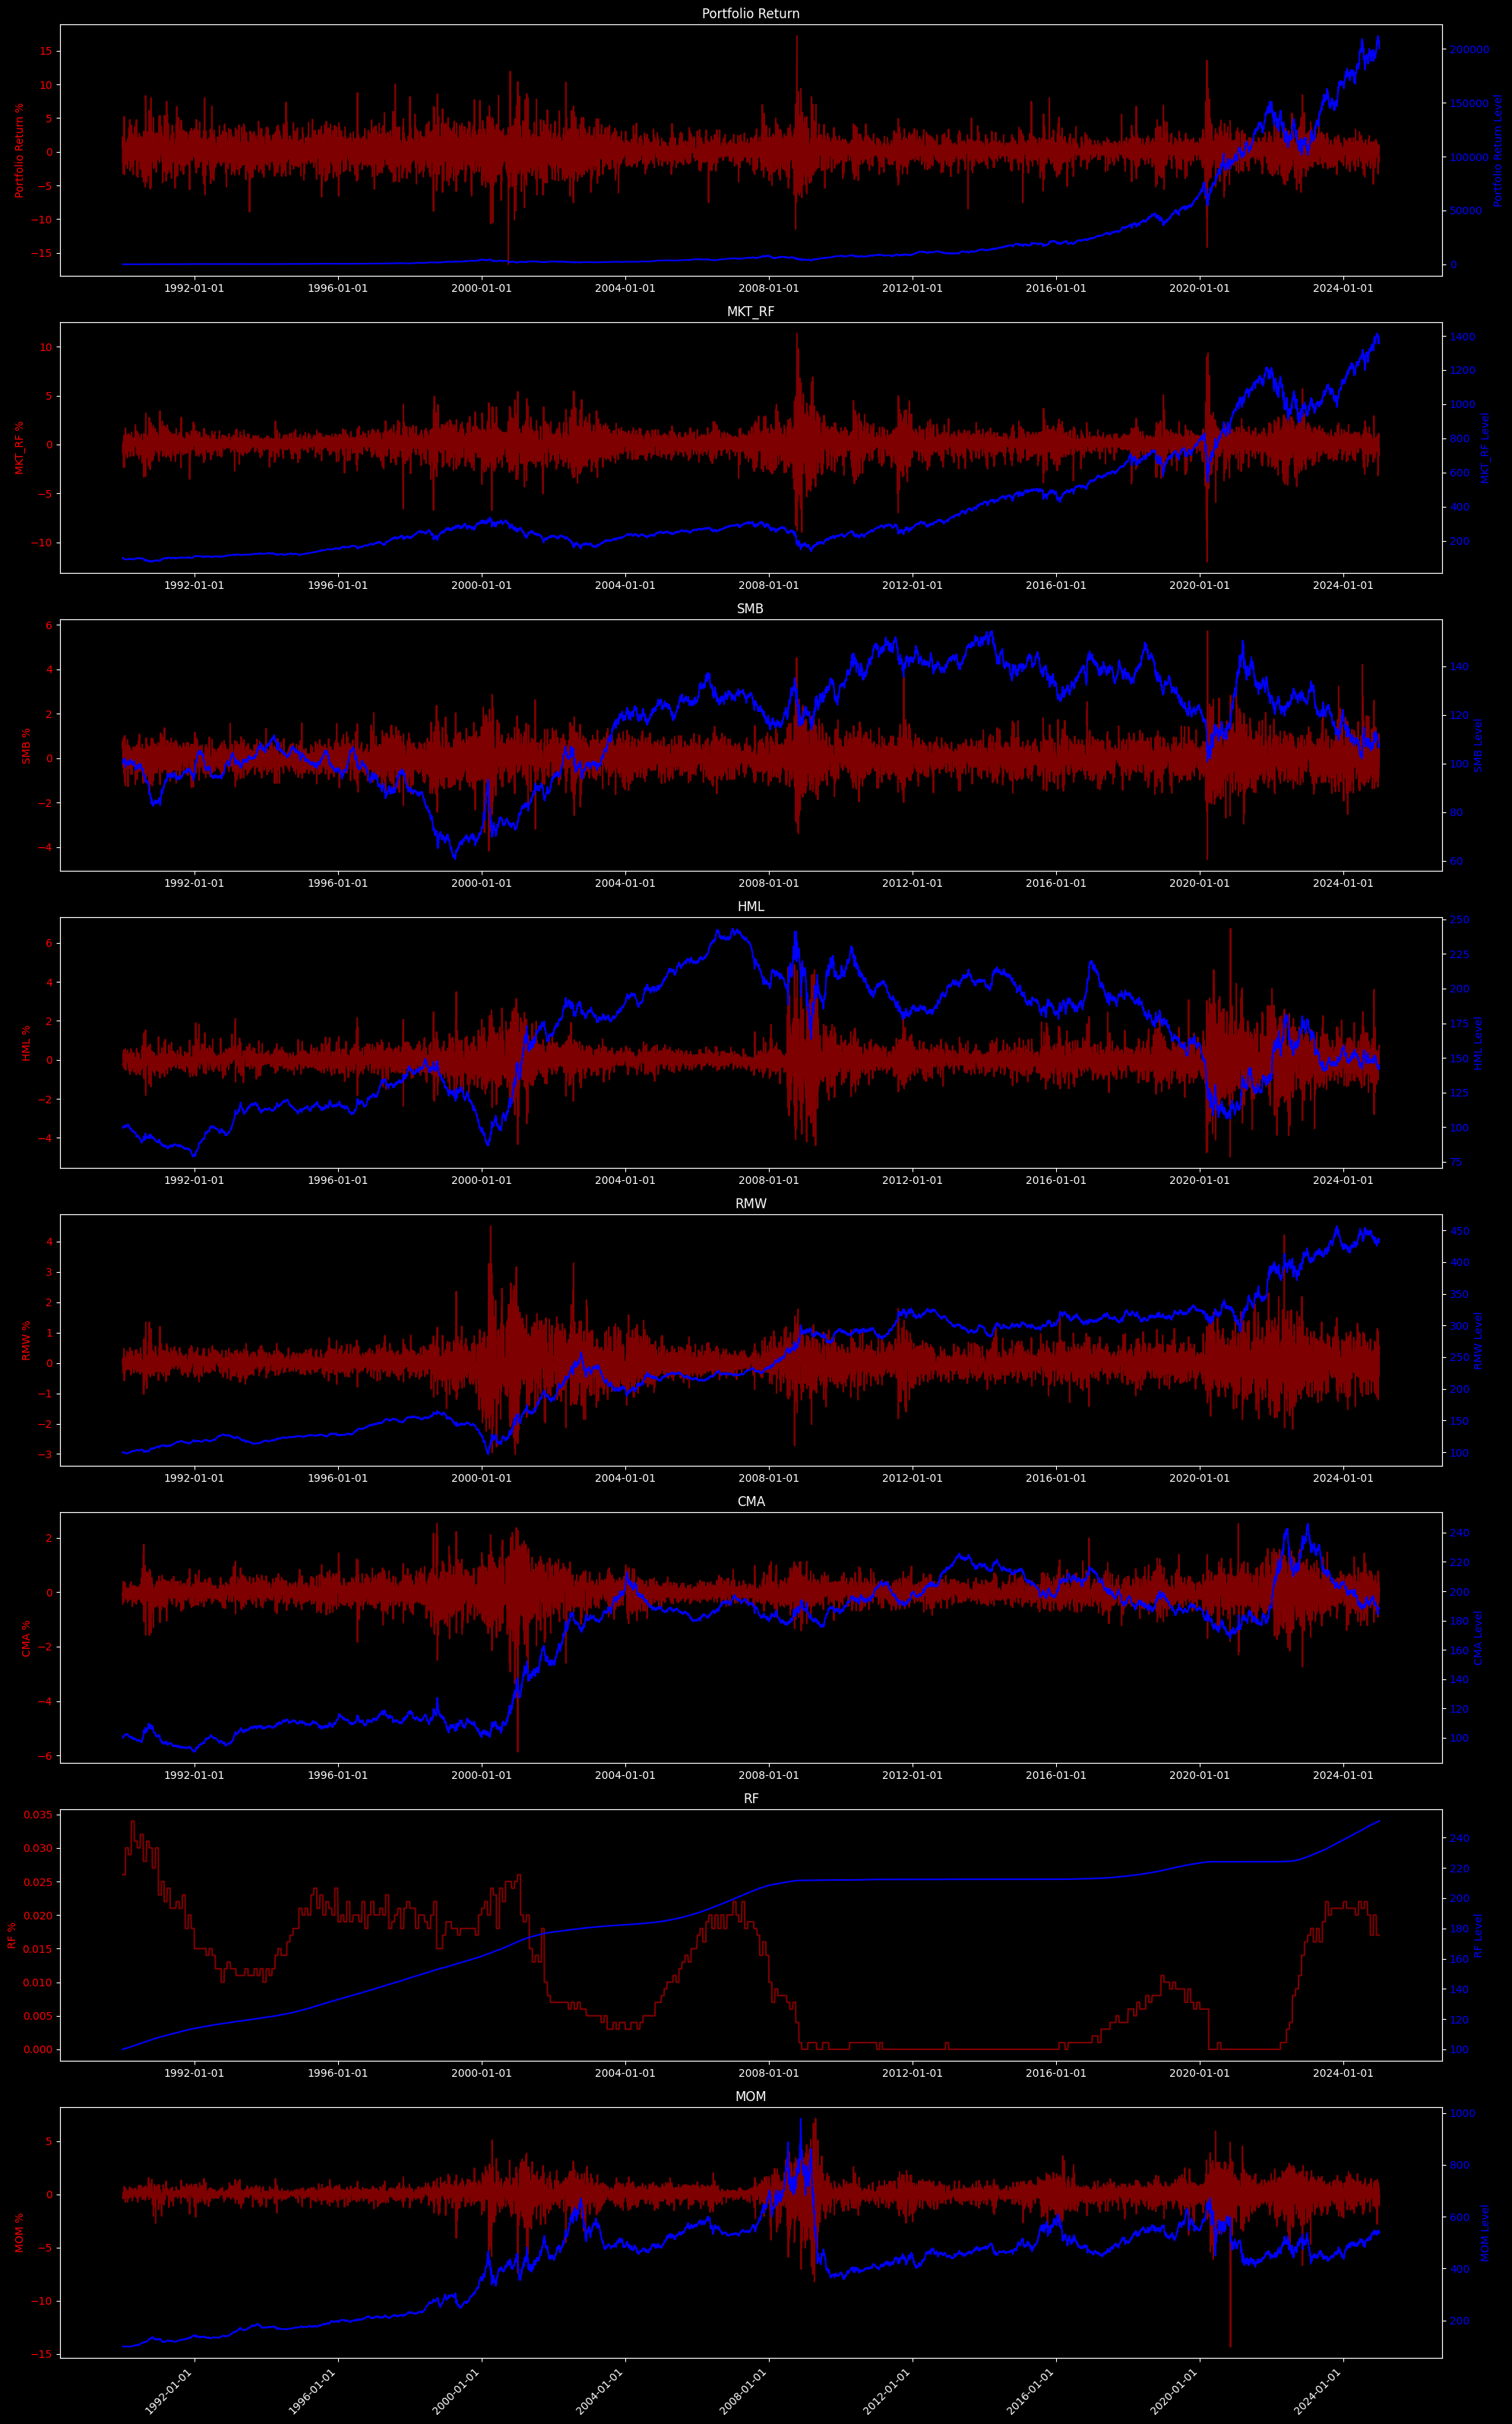

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('dark_background')

# Convert Date to datetime
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Assume stock tickers are defined in variable `tickers`
try:
    stock_ticker_cols = tickers
except NameError:
    stock_ticker_cols = []

# Exclude stock price columns and any daily return columns
exclude_cols = ['Date', 'Adj Close'] + stock_ticker_cols
exclude_cols += [col for col in final_df.columns if 'Daily Return' in col]

cols_to_plot = [col for col in final_df.columns if col not in exclude_cols]

num_plots = len(cols_to_plot)
fig, axes = plt.subplots(num_plots, 1, figsize=(20, 4 * num_plots), sharex=True)

if num_plots == 1:
    axes = [axes]

date_formatter = mdates.DateFormatter("%Y-%m-%d")
for ax in axes:
    ax.xaxis.set_major_formatter(date_formatter)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(labelbottom=True)

for ax, col in zip(axes, cols_to_plot):
    pct_series = final_df[col]
    log_return = np.log1p(pct_series / 100)
    cum_log_return = log_return.cumsum()
    level_series = 100 * np.exp(cum_log_return - cum_log_return.iloc[0])

    # Clip to avoid zeros for log scale
    level_series = level_series.clip(lower=1e-5)

    # Plot percentage series on primary y-axis (red)
    ax.plot(final_df['Date'], pct_series, color='red', label=f'{col} %', alpha=0.5)
    ax.set_ylabel(f'{col} %', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create a second y-axis for the normalized level series (blue)
    ax2 = ax.twinx()
    ax2.plot(final_df['Date'], level_series, color='blue', label=f'{col} Level')
    ax2.set_ylabel(f'{col} Level', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Use log scale if level values are huge
    if level_series.max() > 1e6:
        ax2.set_yscale('log')

    ax.set_title(col)

plt.xlabel('Date')
plt.tight_layout()
plt.show()


# Run OLS Regression on Portfolio Returns

Compute the portfolio's excess return by subtracting the risk-free rate. Use factor returns to explain the excess return. Run an OLS regression with these factors.

In [ ]:
import statsmodels.api as sm

# Compute excess portfolio return.
final_df["Excess Return"] = final_df["Portfolio Return"] - final_df["RF"]

# Select factor returns as independent variables.
X = final_df[["MKT_RF", "SMB", "HML", "RMW", "CMA", "MOM"]]
X = sm.add_constant(X)  # Add the intercept term.

# Set the dependent variable.
y = final_df["Excess Return"]

# Run OLS regression.
model = sm.OLS(y, X).fit()

# Print the regression summary.
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     1857.
Date:                Mon, 10 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:42:23   Log-Likelihood:                -14404.
No. Observations:                8816   AIC:                         2.882e+04
Df Residuals:                    8809   BIC:                         2.887e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0591      0.013      4.465      0.0

# Rolling Regression on Portfolio Excess Returns

Set a rolling window of 252 days (1 year). Compute portfolio excess returns by subtracting the risk-free rate from the portfolio returns. Store the rolling intercept (alpha), betas, and mean absolute error. This version uses portfolio data and removes hard-coded asset names.

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set rolling window (252 trading days ~ 1 year)
window = 252

# Store rolling estimates
rolling_dates = []
rolling_alphas = []
rolling_residuals = []
rolling_betas = {"MKT_RF": [], "SMB": [], "HML": [], "RMW": [], "CMA": [], "MOM": []}

# Perform rolling regressions
for i in range(window, len(final_df)):
    subset = final_df.iloc[i - window: i]  # 1-year window
    # Compute portfolio excess return
    y = subset["Portfolio Return"] - subset["RF"]
    X = subset[["MKT_RF", "SMB", "HML", "RMW", "CMA", "MOM"]]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    # Store results
    rolling_dates.append(final_df.iloc[i]["Date"])
    rolling_alphas.append(model.params["const"])
    rolling_residuals.append(np.mean(np.abs(model.resid)))
    for factor in rolling_betas.keys():
        rolling_betas[factor].append(model.params[factor])

# Convert rolling results into a DataFrame
rolling_results = pd.DataFrame({
    "Date": rolling_dates,
    "Alpha": rolling_alphas,
    "Error": rolling_residuals
})
for factor in rolling_betas.keys():
    rolling_results[f"{factor} Beta"] = rolling_betas[factor]

rolling_results["Date"] = pd.to_datetime(rolling_results["Date"])
rolling_results.set_index("Date", inplace=True)


In [ ]:
rolling_results

,Alpha,Error,MKT_RF Beta,SMB Beta,HML Beta,RMW Beta,CMA Beta,MOM Beta
Date,,,,,,,,
1991-01-02,0.057318,1.119519,0.185826,-0.901551,-2.625492,-0.472950,-1.053580,-0.394460
1991-01-03,0.074273,1.124925,0.194709,-0.886297,-2.585415,-0.524781,-1.087001,-0.437274
1991-01-04,0.092326,1.124784,0.245003,-0.856558,-2.351898,-0.489650,-1.162563,-0.434147
1991-01-07,0.106024,1.122158,0.227273,-0.849916,-2.391730,-0.539502,-1.187947,-0.467105
1991-01-08,0.106045,1.123346,0.215296,-0.851347,-2.404745,-0.545250,-1.191043,-0.468663
...,...,...,...,...,...,...,...,...
2024-12-24,-0.046703,0.473430,1.079559,-0.142156,-0.370498,0.308912,-0.431136,-0.125970
2024-12-26,-0.048289,0.473716,1.077971,-0.140942,-0.371625,0.311665,-0.430155,-0.125362
2024-12-27,-0.045879,0.473525,1.076898,-0.136951,-0.372689,0.311289,-0.428871,-0.124353


# Plot Rolling Regression Results for Portfolio
Plot three subplots. The first shows rolling factor betas and alpha. The second displays portfolio value and daily returns with shaded regions for overvalued/undervalued periods. The third shows the rolling regression error.

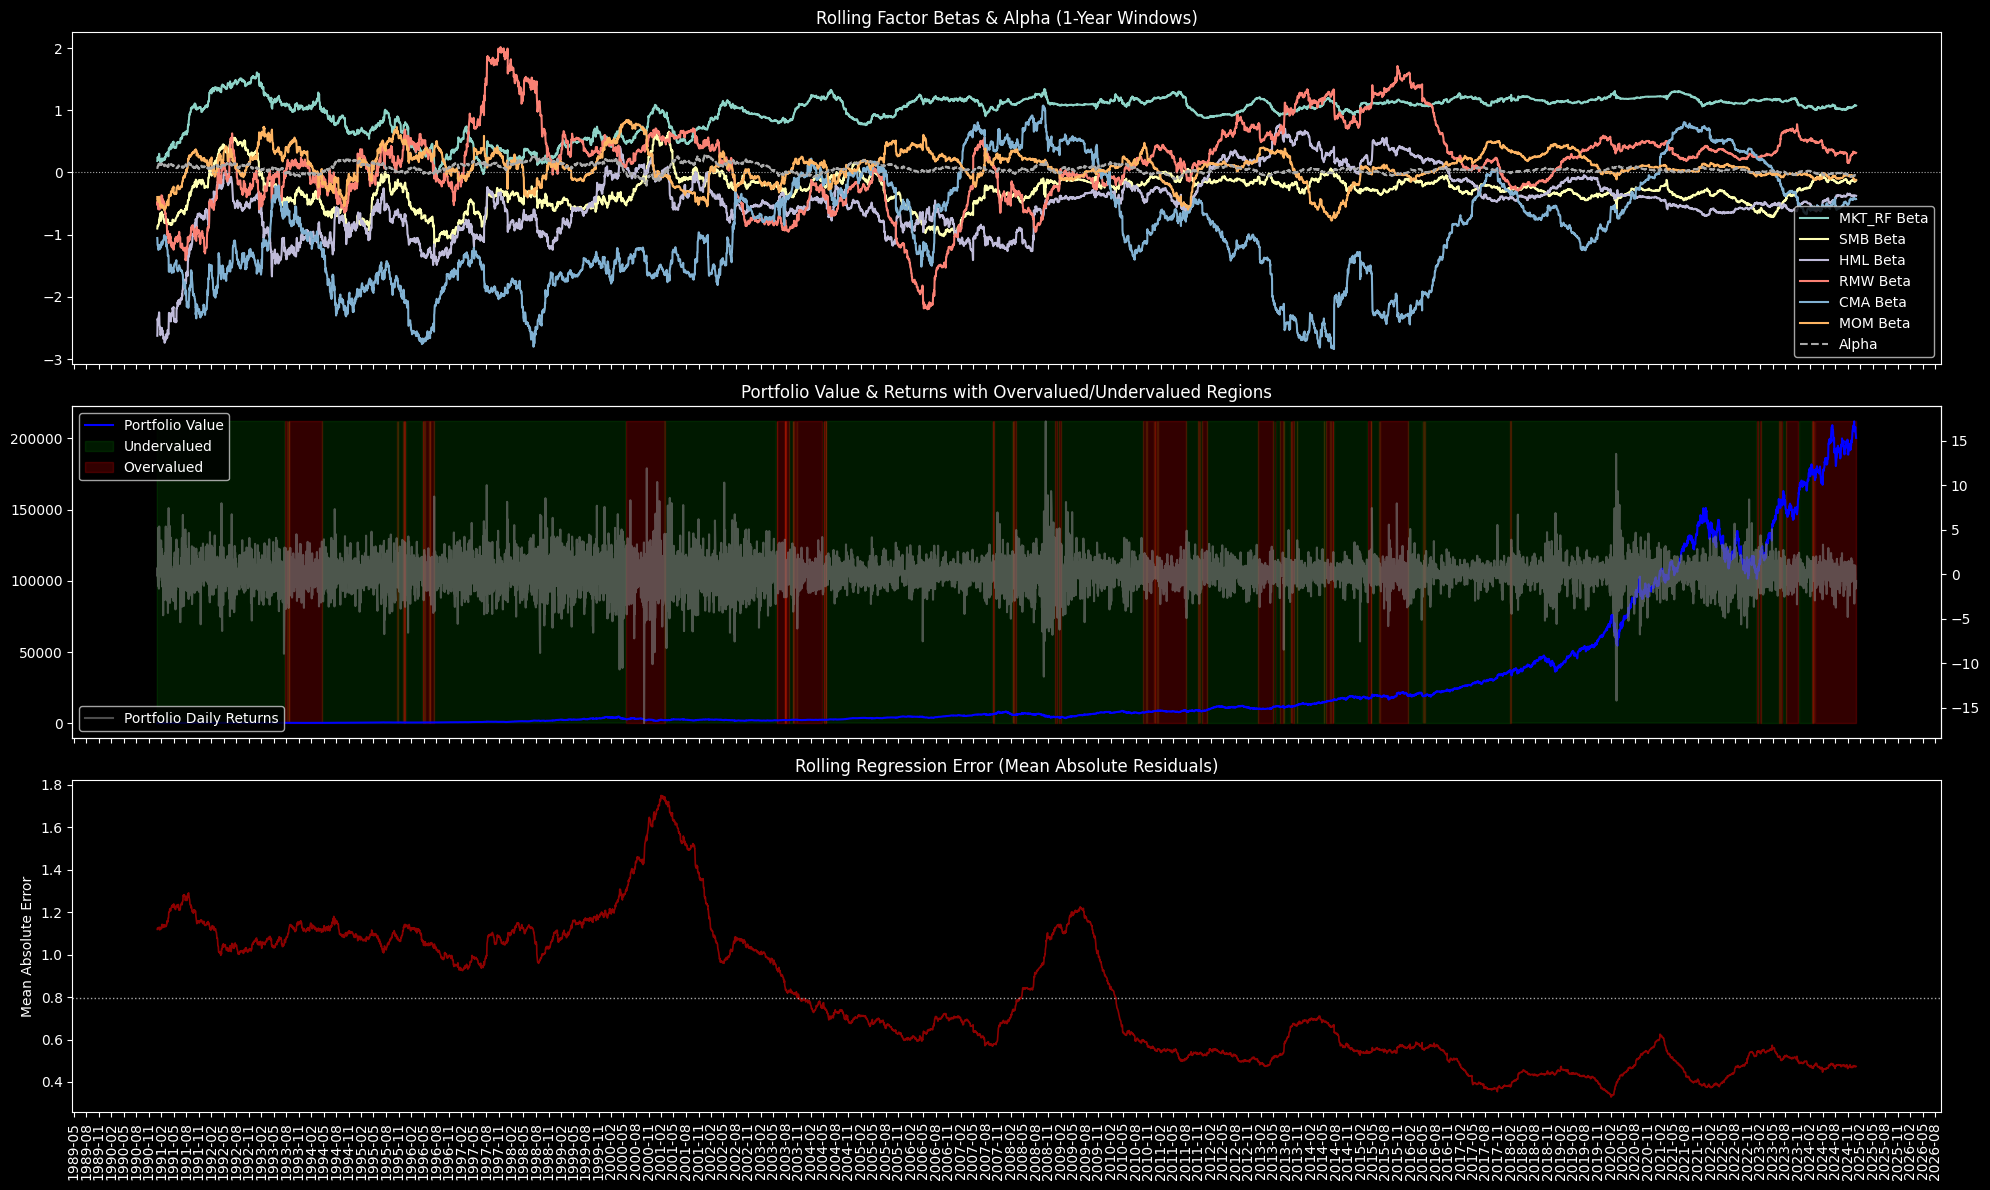

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure final_df has Date as a datetime index.
final_df_date = final_df.copy()
final_df_date["Date"] = pd.to_datetime(final_df_date["Date"])
final_df_date.set_index("Date", inplace=True)

# Compute portfolio value series from portfolio returns.
portfolio_pct_series = final_df_date["Portfolio Return"]
log_return = np.log1p(portfolio_pct_series / 100)
cum_log_return = log_return.cumsum()
portfolio_prices = 100 * np.exp(cum_log_return - cum_log_return.iloc[0])
portfolio_returns = final_df_date["Portfolio Return"]

# Reindex portfolio series to match rolling regression results.
portfolio_prices_rolling = portfolio_prices.reindex(rolling_results.index)
portfolio_returns_rolling = portfolio_returns.reindex(rolling_results.index)

# Create 3 subplots with shared x-axis.
fig, axes = plt.subplots(3, 1, figsize=(20, 12), sharex=True)

# Plot rolling factor betas and alpha.
ax = axes[0]
for factor in rolling_betas.keys():
    ax.plot(rolling_results.index, rolling_results[f"{factor} Beta"], label=f"{factor} Beta")
ax.plot(rolling_results.index, rolling_results["Alpha"], color="darkgray", linestyle="dashed", label="Alpha")
ax.set_title("Rolling Factor Betas & Alpha (1-Year Windows)")
ax.axhline(0, color="darkgray", linewidth=0.8, linestyle="dotted")
ax.legend()

# Plot portfolio value and daily returns on separate axes.
ax2 = axes[1]
ax3 = ax2.twinx()  # Secondary y-axis.
ax2.plot(portfolio_prices_rolling.index, portfolio_prices_rolling, label="Portfolio Value", color="blue", linewidth=1.5)
ax3.plot(portfolio_returns_rolling.index, portfolio_returns_rolling, label="Portfolio Daily Returns", color="gray", alpha=0.6)

# Shade regions based on alpha from rolling regression.
undervalued = rolling_results["Alpha"] > 0
min_val = portfolio_prices_rolling.min()
max_val = portfolio_prices_rolling.max()
ax2.fill_between(rolling_results.index, min_val, max_val,
                 where=undervalued, color="green", alpha=0.2, label="Undervalued")
ax2.fill_between(rolling_results.index, min_val, max_val,
                 where=~undervalued, color="red", alpha=0.2, label="Overvalued")

ax2.set_title("Portfolio Value & Returns with Overvalued/Undervalued Regions")
ax2.legend(loc="upper left")
ax3.legend(loc="lower left")

# Plot rolling regression error (mean absolute residuals).
ax4 = axes[2]
ax4.plot(rolling_results.index, rolling_results["Error"], color="darkred", linewidth=1.2)
ax4.set_title("Rolling Regression Error (Mean Absolute Residuals)")
ax4.axhline(rolling_results["Error"].mean(), color="darkgray", linestyle="dotted", linewidth=1)
ax4.set_ylabel("Mean Absolute Error")

# Set x-axis ticks every 3 months and format dates.
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=90, ha="center")

plt.tight_layout()
plt.show()


# Statistical Tests on Rolling Alpha
Perform several tests on the rolling regression alpha from portfolio returns. First, use the ADF test for stationarity. Then, fit an AR(1) model to check for mean reversion and calculate the half-life. Finally, run a custom variance ratio test.

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings("ignore")

# Create a copy of the rolling results DataFrame
df_copy = rolling_results.copy()

# Drop NaN values for analysis
df_copy = df_copy.dropna(subset=['Alpha'])

# -------------------------------
# 1. Augmented Dickey-Fuller (ADF) Test
# -------------------------------
adf_result = adfuller(df_copy['Alpha'])

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("Alpha is mean-reverting (stationary)")
else:
    print("Alpha follows a random walk (not mean-reverting)")

# -------------------------------
# 2. Autoregressive Model (AR-1)
# -------------------------------
ar_model = AutoReg(df_copy['Alpha'], lags=1).fit()
rho = ar_model.params[1]  # AR(1) coefficient

print(f"AR(1) Coefficient (rho): {rho}")
if rho < 1:
    print("Alpha is mean-reverting")
else:
    print("Alpha follows a random walk")

# -------------------------------
# 3. Half-Life Calculation
# -------------------------------
half_life = np.log(0.5) / np.log(abs(rho))

print(f"Half-Life of Alpha: {half_life} periods")
if half_life < 20:
    print("Alpha reverts quickly (short-term inefficiency)")
else:
    print("Alpha takes longer to revert (persistent mispricing)")

# -------------------------------
# 4. Custom Variance Ratio Test
# -------------------------------
def variance_ratio_test(series, lag=4):
    series = series.dropna()

    # Compute variances
    var_1 = np.var(series.diff(1).dropna(), ddof=1)
    var_k = np.var(series.diff(lag).dropna(), ddof=1)

    # Variance ratio
    vr_stat = var_k / (var_1 * lag)
    return vr_stat

vr_stat = variance_ratio_test(df_copy['Alpha'], lag=4)

print(f"Variance Ratio: {vr_stat}")
if vr_stat < 1:
    print("Alpha is mean-reverting")
else:
    print("Alpha follows a random walk")


ADF Statistic: -4.85362763884568
p-value: 4.2895579677989856e-05
Alpha is mean-reverting (stationary)
AR(1) Coefficient (rho): 0.9950044098509443
Alpha is mean-reverting
Half-Life of Alpha: 138.4049482030796 periods
Alpha takes longer to revert (persistent mispricing)
Variance Ratio: 0.9462945734354862
Alpha is mean-reverting


# Rolling Half-Life of Portfolio Alpha
Compute the rolling half-life of portfolio alpha using an AR(1) model. This code calculates the half-life for each window and plots the rolling half-life along with a reference line.

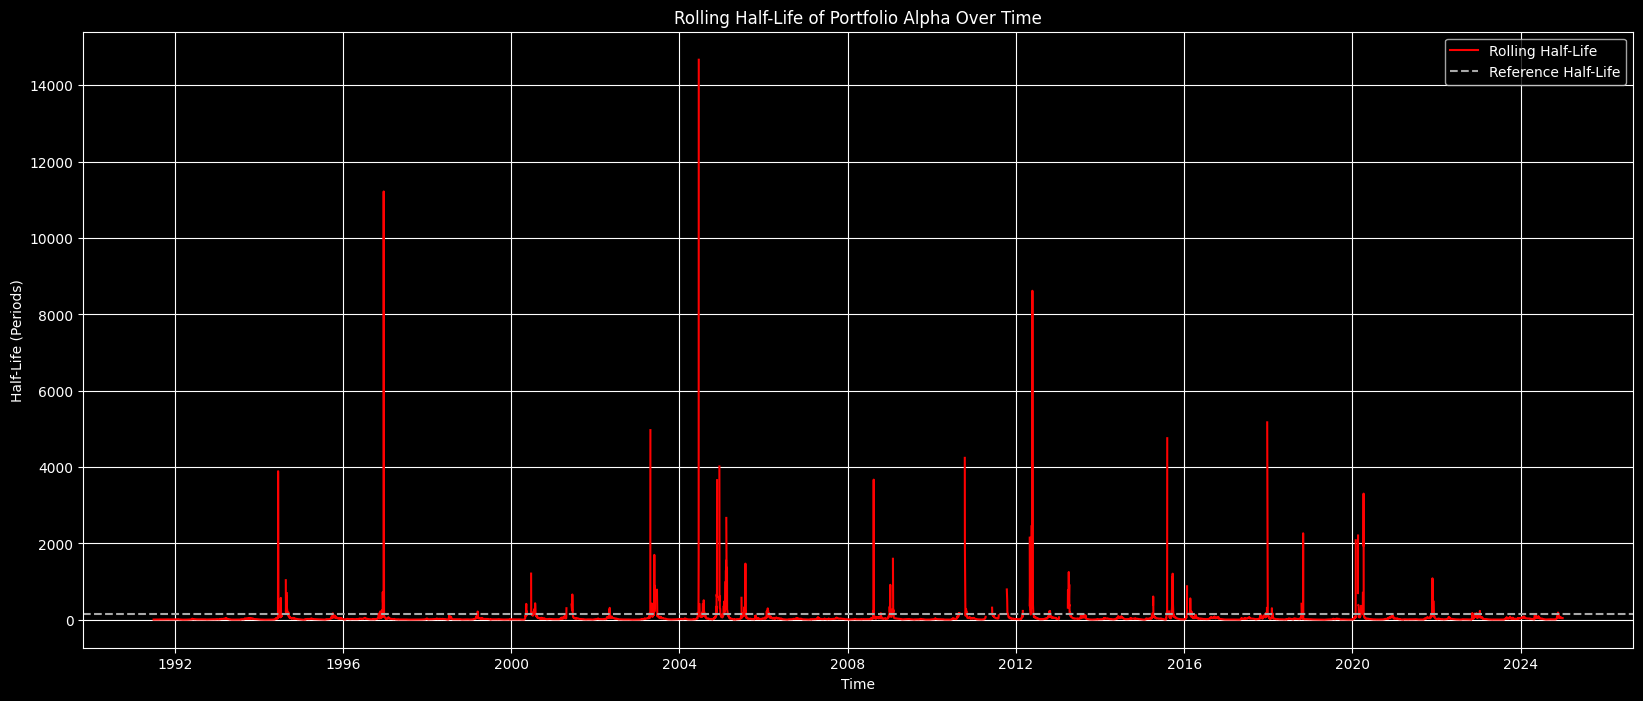

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# Create a copy of the rolling_results DataFrame
df_copy = rolling_results.copy()

# Drop NaN values for Alpha
df_copy = df_copy.dropna(subset=['Alpha'])

# Define rolling window size (e.g., 126 trading days)
rolling_window = 126

# Compute rolling AR(1) coefficient (rho) and half-life
rolling_half_life = []

for i in range(len(df_copy) - rolling_window):
    window_data = df_copy['Alpha'].iloc[i:i+rolling_window]

    # Fit AR(1) model
    try:
        ar_model = AutoReg(window_data, lags=1).fit()
        rho = ar_model.params[1]  # AR(1) coefficient

        # Compute half-life if rho is valid
        if abs(rho) < 1:
            half_life = np.log(0.5) / np.log(abs(rho))
        else:
            half_life = np.nan
    except:
        half_life = np.nan

    rolling_half_life.append(half_life)

# Align results with the original index
df_copy = df_copy.iloc[rolling_window:].copy()
df_copy['Rolling_Half_Life'] = rolling_half_life

# Plot Rolling Half-Life
plt.figure(figsize=(20, 8))
plt.plot(df_copy.index, df_copy['Rolling_Half_Life'], color='red', label="Rolling Half-Life")
plt.axhline(y=145, color='darkgray', linestyle='dashed', label="Reference Half-Life")
plt.xlabel("Time")
plt.ylabel("Half-Life (Periods)")
plt.title("Rolling Half-Life of Portfolio Alpha Over Time")
plt.legend()
plt.grid(True)
plt.show()


# Scatter Plot: Expected vs. Actual Excess Return (Portfolio)
Compute the expected portfolio excess return using rolling factor betas. Compare it with the actual excess return (portfolio return minus RF). Then plot a scatter chart with a regression line and display R².

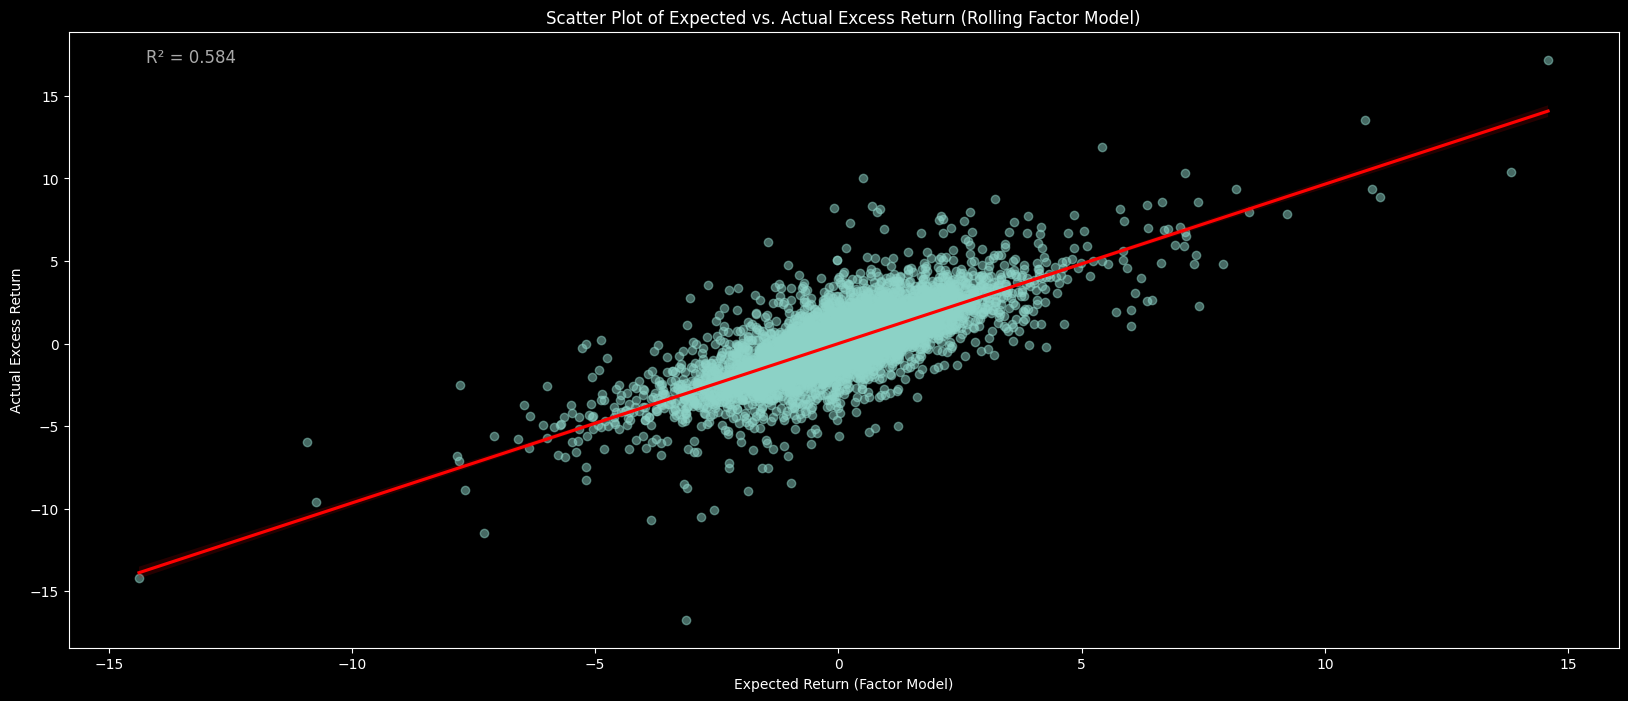

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute Expected Return using rolling factor betas
expected_return = (
    rolling_results["Alpha"] +
    rolling_results["MKT_RF Beta"] * final_df.set_index("Date").loc[rolling_results.index, "MKT_RF"] +
    rolling_results["SMB Beta"]   * final_df.set_index("Date").loc[rolling_results.index, "SMB"] +
    rolling_results["HML Beta"]   * final_df.set_index("Date").loc[rolling_results.index, "HML"] +
    rolling_results["RMW Beta"]   * final_df.set_index("Date").loc[rolling_results.index, "RMW"] +
    rolling_results["CMA Beta"]   * final_df.set_index("Date").loc[rolling_results.index, "CMA"] +
    rolling_results["MOM Beta"]   * final_df.set_index("Date").loc[rolling_results.index, "MOM"]
)

# Get Actual Excess Return using portfolio returns
actual_excess_return = (
    final_df.set_index("Date").loc[rolling_results.index, "Portfolio Return"] -
    final_df.set_index("Date").loc[rolling_results.index, "RF"]
)

# Create scatter plot with regression line
plt.figure(figsize=(20, 8))
sns.regplot(x=expected_return, y=actual_excess_return,
            scatter_kws={'alpha': 0.5}, line_kws={"color": "red"})

plt.xlabel("Expected Return (Factor Model)")
plt.ylabel("Actual Excess Return")
plt.title("Scatter Plot of Expected vs. Actual Excess Return (Rolling Factor Model)")

# Compute R² (model accuracy)
corr_matrix = np.corrcoef(expected_return, actual_excess_return)
r_squared = corr_matrix[0, 1] ** 2
plt.annotate(f"R² = {r_squared:.3f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color="darkgray")

plt.show()


# Return Attribution Approaches for Portfolio Excess Return
The first panel uses a compounded (chain-linking) approach to compute cumulative factor contributions to the portfolio’s excess return. The second panel computes a simple arithmetic cumulative sum of daily factor contributions. The third panel compares the actual compounded portfolio excess return with the total attribution from the compounded method.

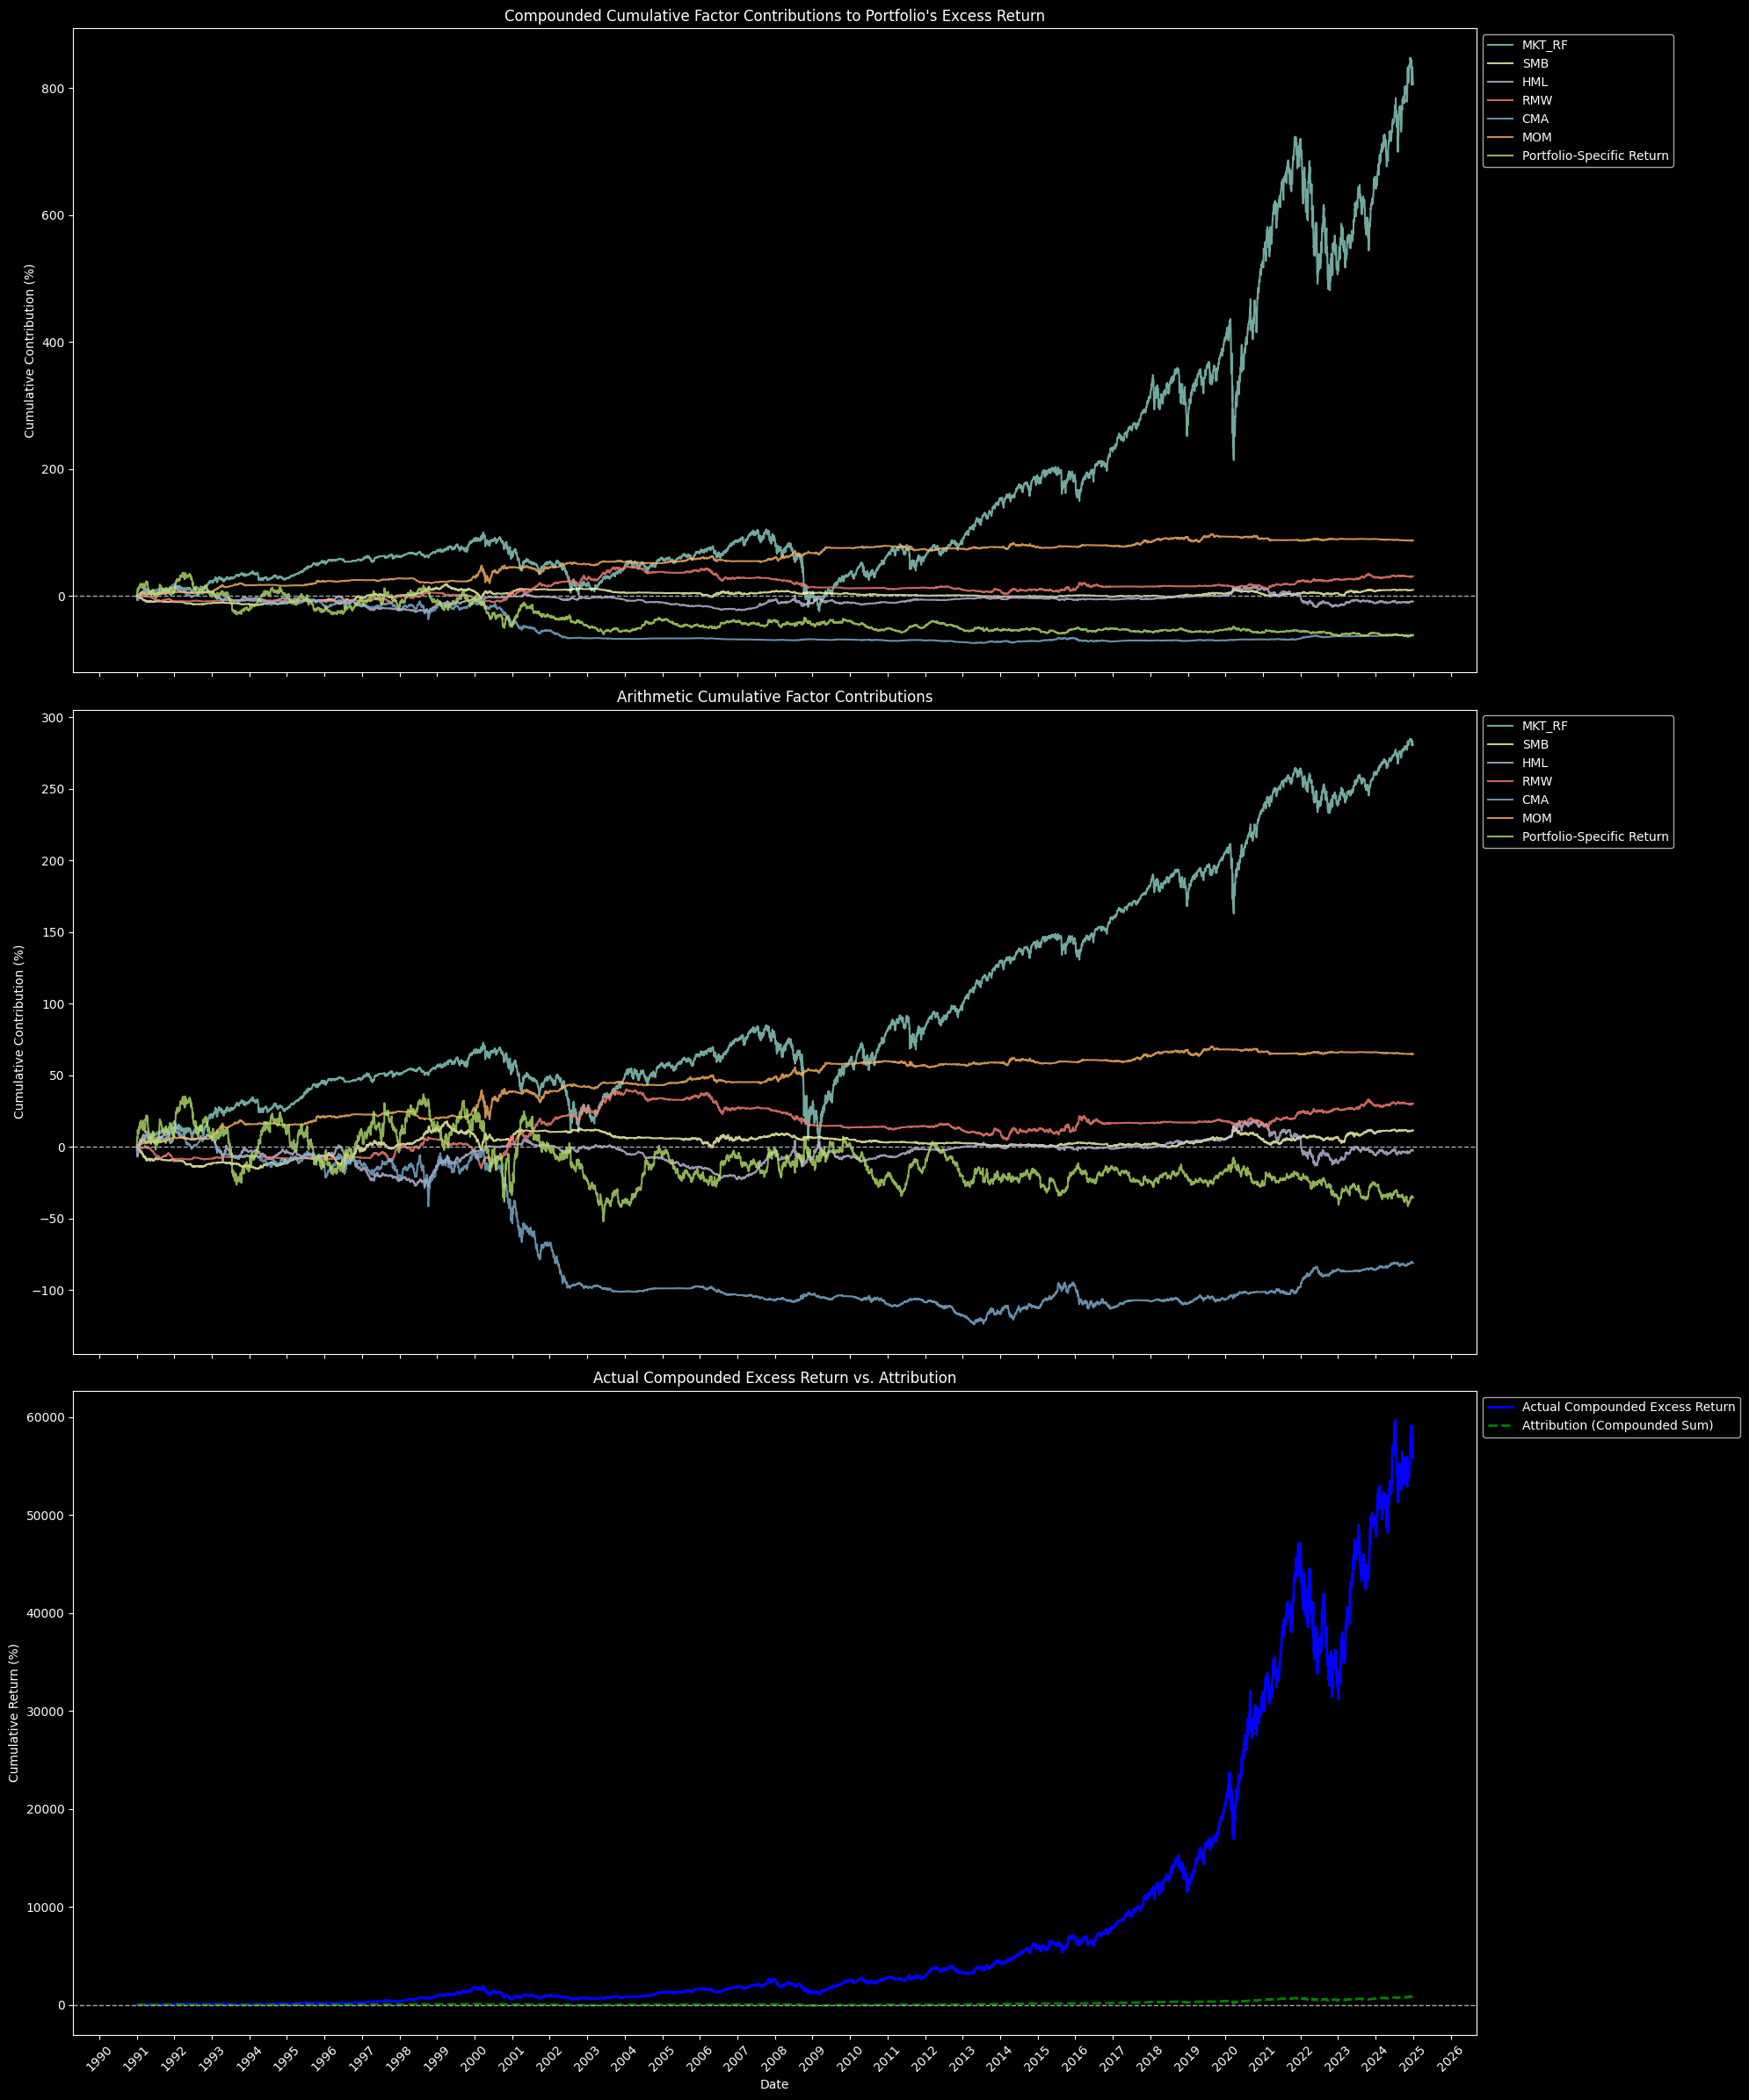

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Compute expected factor contributions.
factor_contributions = {}
for factor in rolling_betas.keys():
    factor_contributions[factor] = rolling_results[f"{factor} Beta"] * final_df.set_index("Date").loc[rolling_results.index, factor]

# Compute portfolio-specific residual return (unexplained return).
expected_return = sum(factor_contributions.values()) + rolling_results["Alpha"]
unexplained_return = (final_df.set_index("Date").loc[rolling_results.index, "Portfolio Return"] -
                      final_df.set_index("Date").loc[rolling_results.index, "RF"] -
                      expected_return)

# Convert to DataFrame.
factor_contributions_df = pd.DataFrame(factor_contributions)
factor_contributions_df["Portfolio-Specific Return"] = unexplained_return

# Approach 1: Compounded Cumulative Returns (Chain-linking).
# Convert daily percentage contributions to decimals, compound them, and convert back.
factor_contributions_compounded = (1 + factor_contributions_df / 100).cumprod() - 1
factor_contributions_compounded = factor_contributions_compounded * 100  # Express as percentage

# Approach 2: Arithmetic (Simple Cumulative Sum).
factor_contributions_arith = factor_contributions_df.cumsum()

# Actual Portfolio Excess Return (compounded).
actual_excess_return = (final_df.set_index("Date").loc[rolling_results.index, "Portfolio Return"] -
                        final_df.set_index("Date").loc[rolling_results.index, "RF"])
actual_excess_compounded = (1 + actual_excess_return / 100).cumprod() - 1
actual_excess_compounded = actual_excess_compounded * 100

# Plotting: Three subplots.
fig, axs = plt.subplots(3, 1, figsize=(20, 24), sharex=True)

# Subplot 1: Compounded Cumulative Factor Contributions (Original Approach).
ax = axs[0]
for column in factor_contributions_compounded.columns:
    ax.plot(factor_contributions_compounded.index, factor_contributions_compounded[column],
            label=column, alpha=0.8)
ax.set_title("Compounded Cumulative Factor Contributions to Portfolio's Excess Return")
ax.set_ylabel("Cumulative Contribution (%)")
ax.axhline(0, color="darkgray", linewidth=1, linestyle="dashed")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=45)

# Subplot 2: Arithmetic Cumulative Factor Contributions.
ax = axs[1]
for column in factor_contributions_arith.columns:
    ax.plot(factor_contributions_arith.index, factor_contributions_arith[column],
            label=column, alpha=0.8)
ax.set_title("Arithmetic Cumulative Factor Contributions")
ax.set_ylabel("Cumulative Contribution (%)")
ax.axhline(0, color="darkgray", linewidth=1, linestyle="dashed")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=45)

# Subplot 3: Comparison with Actual Compounded Portfolio Excess Return.
ax = axs[2]
# Sum of compounded attributions.
total_compounded_attribution = factor_contributions_compounded.sum(axis=1)
ax.plot(actual_excess_compounded.index, actual_excess_compounded,
        label="Actual Compounded Excess Return", color="blue", linewidth=2)
ax.plot(total_compounded_attribution.index, total_compounded_attribution,
        label="Attribution (Compounded Sum)", color="green", linestyle="--", linewidth=2)
ax.set_title("Actual Compounded Excess Return vs. Attribution")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return (%)")
ax.axhline(0, color="darkgray", linewidth=1, linestyle="dashed")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()
